# FNS-Dogleg Duct benchmark analysis 
*FNS-duct* is an intermediate quality neutronics experiment conducted to test the effect of a dogleg duct in a ITER shielding mockup [1]. \
Neutronics code results are compared to the experiment measurements. \
Measurements include:
- Flux evaluation via activation foil reaction rate detection
- Energy spectra evaluated via spherical NE213 scintillation spectrometer

It is worth to mention that the OpenMC simulation relies on the _weight windows_ variance reduction technique. A local weight windows file (with _wwinp_ extension) has been produced through a CADIS simulation in Attila4MC [2].

Model, experimental results and MCNP results were provided by the SINBAD repository [3].

The 14 MeV neutron source characteristics of FNS was not provided. FNG neutron source characheristics has been used in substitution.

In [1]:
import openmc_fusion_benchmarks as ofb

### Extract experimental and codes results from `results_database`

In [2]:
# read sinbad data
experiment_file = ofb.ResultsFromDatabase('results_database/experiment.h5')
mcnp_jendl33_file = ofb.ResultsFromDatabase('results_database/mcnp-4b-c_jendl33.h5')
mcnp_fendl2_file = ofb.ResultsFromDatabase('results_database/mcnp-4b-c_fendl2.h5')

In [3]:
# read openmc results in results_database/
openmc_fendl3_file = ofb.ResultsFromDatabase('results_database/openmc-0-14-0_fendl32b.h5')
openmc_endfb8_file = ofb.ResultsFromDatabase('results_database/openmc-0-14-0_endfb80.h5')

### Activation foils - reaction rate analysis
The following reaction rates are included:
- $^{93}Nb(n,2n)^{92m}Nb$
- $^{115}In(n,n')^{115m}Co$
- $^{197}Au(n,\gamma)^{198}Au$

OpenMC evaluation of the reaction rates relies on the **_IRDFF-II_** dosimetry nuclear data library [4]. While the rest of the transport relies on the nuclear data libraries specified in the legend of the plots. A _flux multiplier_ is applied to a _track-length flux_ tally is applied on the foil _cells_.

In [4]:
# initialize reaction rate plots
foil_list = ['nb93', 'in115', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{115}$In(n,n\')$^{115m}$In', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

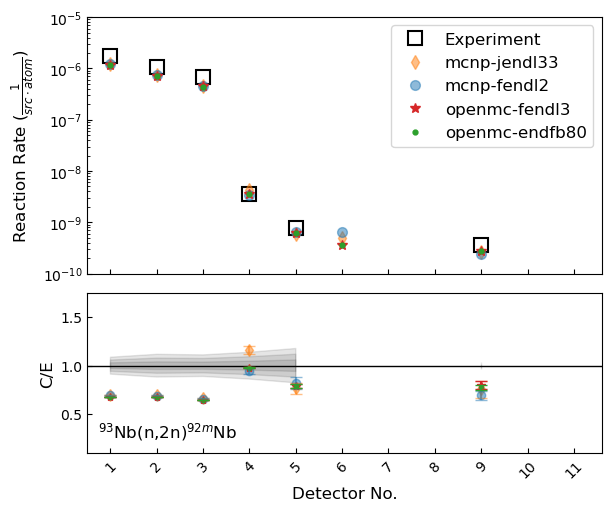

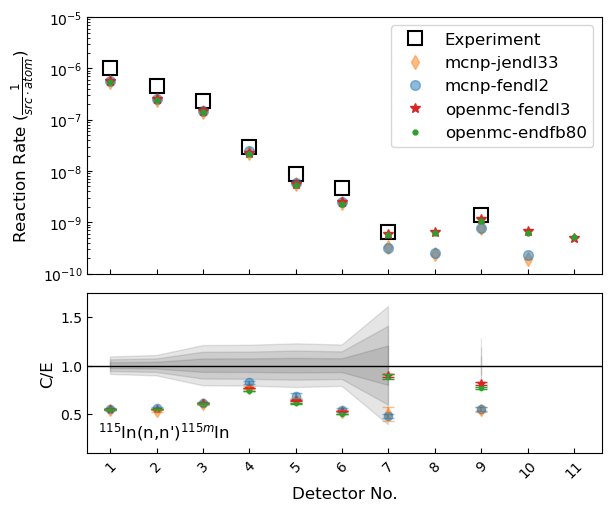

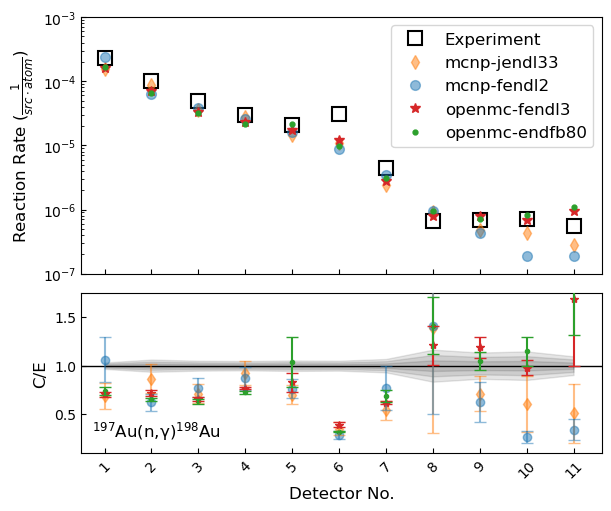

In [5]:
for i,foil in enumerate(foil_list):

    dtype_label = reaction_labels[i]

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_{foil}')
    mcnp_jendl33 = mcnp_jendl33_file.get_tally_dataframe(f'rr_{foil}')
    mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_{foil}')
    
    # openmc from results_database/
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'rr_{foil}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'rr_{foil}')

    xaxis = experiment_file.get_tally_xaxis(f'rr_{foil}')

    # plot results and compare
    plot = ofb.PlotReactionRates(xaxis=xaxis, ylabel=ylabel, dtype_label=dtype_label)
    plot.add_reference_results(reference_data=measured, label='Experiment')
    plot.add_computed_results(computed_data=mcnp_jendl33, marker='d', color='tab:orange', alpha=.5, label='mcnp-jendl33')
    plot.add_computed_results(computed_data=mcnp_fendl2, marker='o', color='tab:blue', alpha=.5, label='mcnp-fendl2')
    plot.add_computed_results(computed_data=openmc_fendl3, marker='*', color='tab:red', label='openmc-fendl3')
    plot.add_computed_results(computed_data=openmc_endfb8, marker='.', color='tab:green', label='openmc-endfb80')

### Spectrometers - neutron energy spectra

Neutron energy spectra measured via NE213 liquid organic scintillators in four different position and depths in within the dogleg duct.

Experimental and MCNP computational results are provided with a different energy binning. We will show both the binning options by rebinning all computational results according to the experimental first and vice-versa in the following notebook cell.

In [6]:
# initialize spectra data
detector_list = ['detector3', 'detector5', 'detector7', 'detector9']
detector_labels = ['detector 3', 'detector 5', 'detector 7', 'detector 9']
ylabel = r'Flux $(\frac{n}{cm^2 \cdot src \cdot lethargy})$'

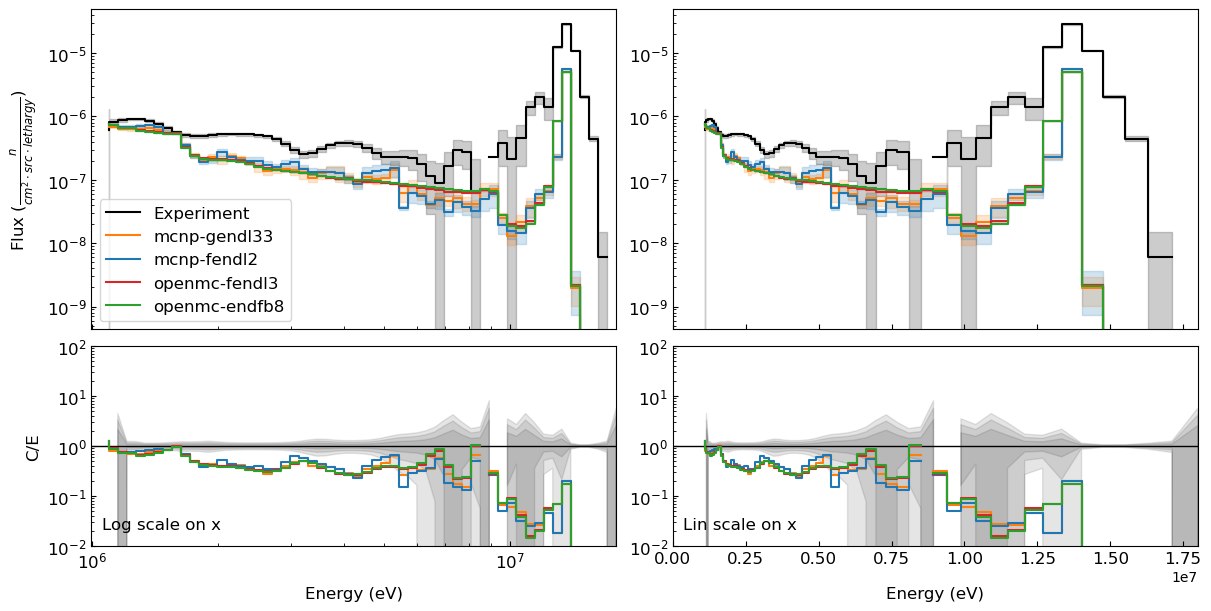

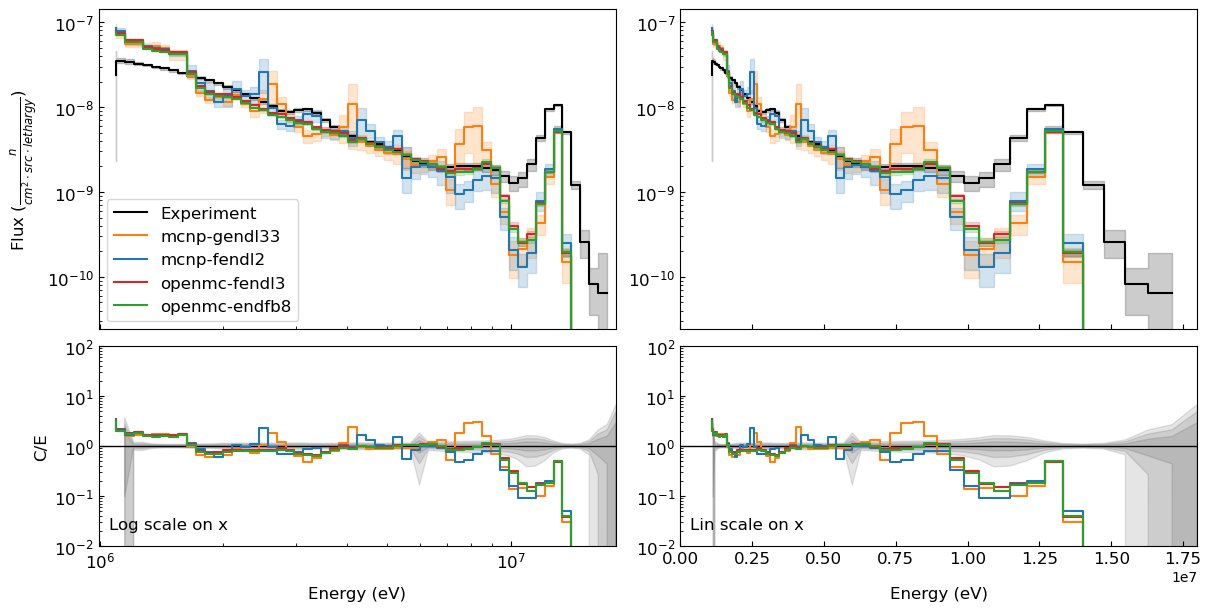

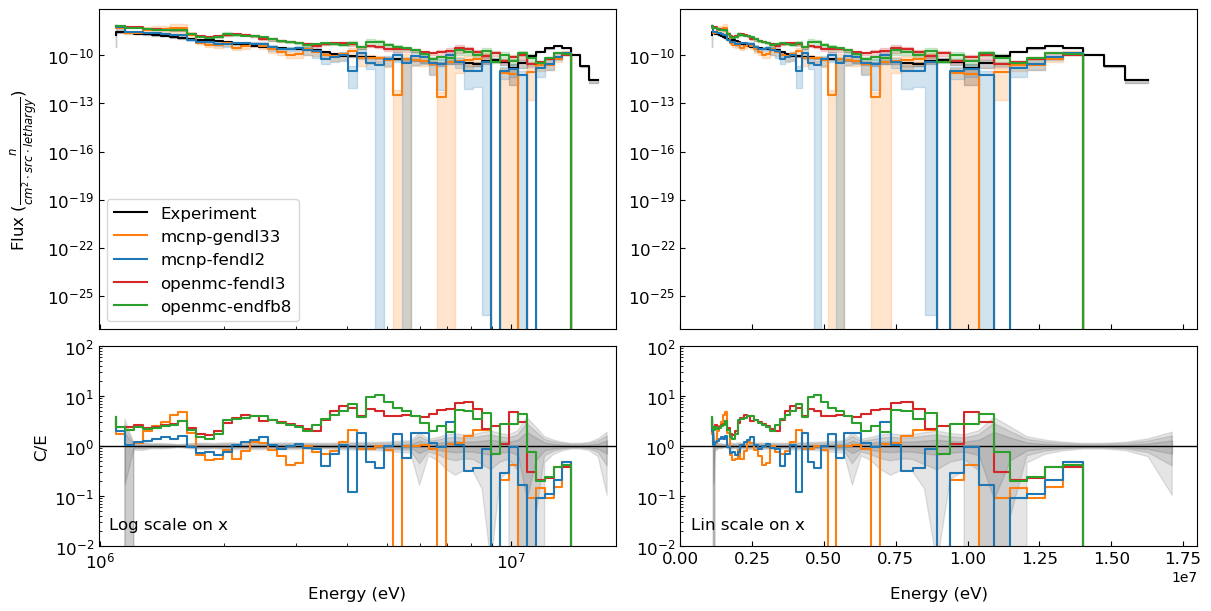

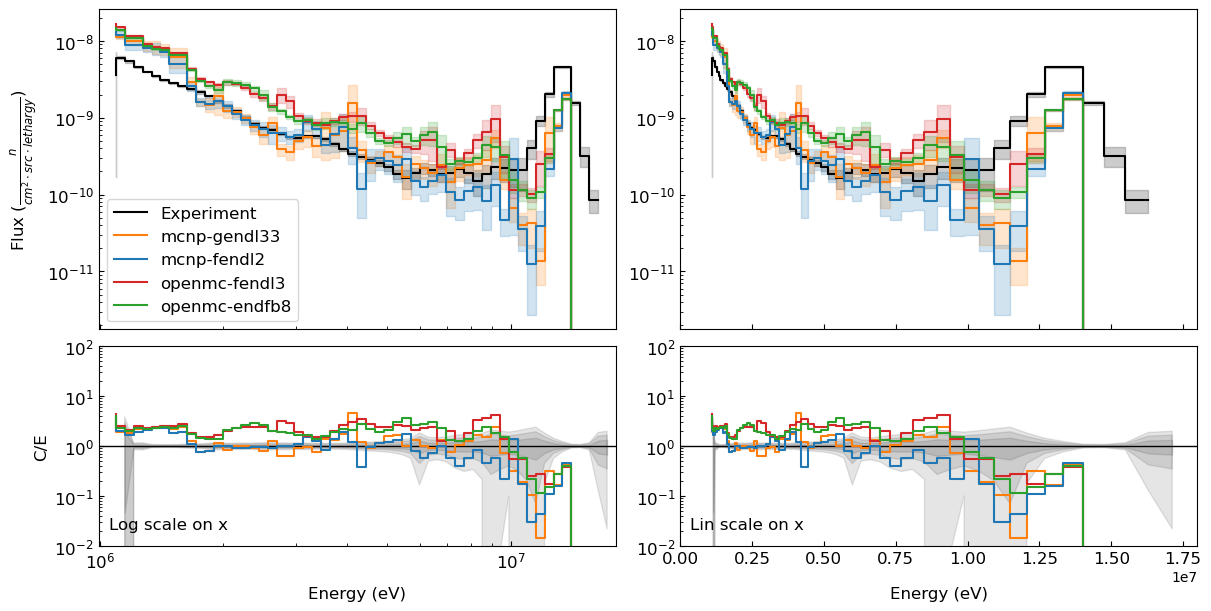

In [7]:
# Spectra with experimental results binning

for i, dl in enumerate(detector_list):

    measured = experiment_file.get_tally_dataframe(f'nspectrum_{dl}')
    mcnp_jendl33 = mcnp_jendl33_file.get_tally_dataframe(f'nspectrum_{dl}')
    mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'nspectrum_{dl}')
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'nspectrum_{dl}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'nspectrum_{dl}')

    # plot
    # preprocessing
    measured = ofb.rescale_to_lethargy(measured)
    mcnp_jendl33 = ofb.rescale_to_lethargy(ofb.rebin_spectrum(mcnp_jendl33, measured['energy low [eV]'], measured['energy high [eV]']))
    mcnp_fendl2 = ofb.rescale_to_lethargy(ofb.rebin_spectrum(mcnp_fendl2, measured['energy low [eV]'], measured['energy high [eV]']))
    openmc_fendl3 = ofb.rescale_to_lethargy(ofb.rebin_spectrum(openmc_fendl3, measured['energy low [eV]'], measured['energy high [eV]']))
    openmc_endfb8 = ofb.rescale_to_lethargy(ofb.rebin_spectrum(openmc_endfb8, measured['energy low [eV]'], measured['energy high [eV]']))

    # generate figure
    plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel, dtype_label=detector_labels[i])
    plot.add_reference_results(reference_data=measured, label='Experiment')
    plot.add_computed_results(computed_data=mcnp_jendl33, color='tab:orange', alpha=1, label='mcnp-gendl33')
    plot.add_computed_results(computed_data=mcnp_fendl2, color='tab:blue', alpha=1, label='mcnp-fendl2')
    plot.add_computed_results(computed_data=openmc_fendl3, color='tab:red', alpha=1, label='openmc-fendl3')
    plot.add_computed_results(computed_data=openmc_endfb8, color='tab:green', alpha=1, label='openmc-endfb8')

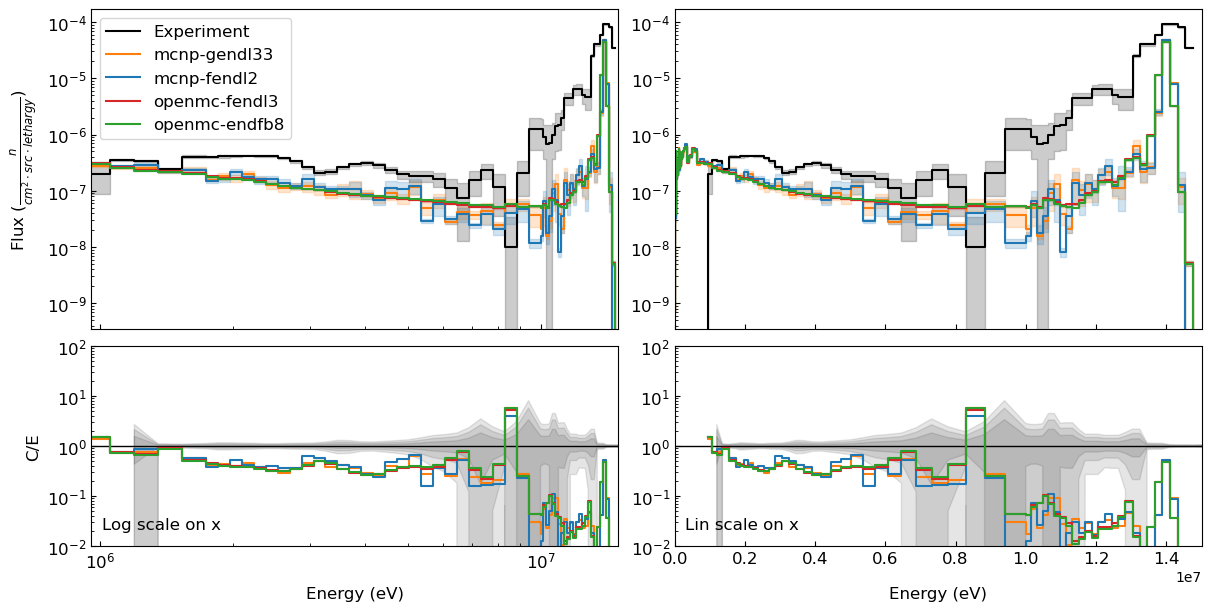

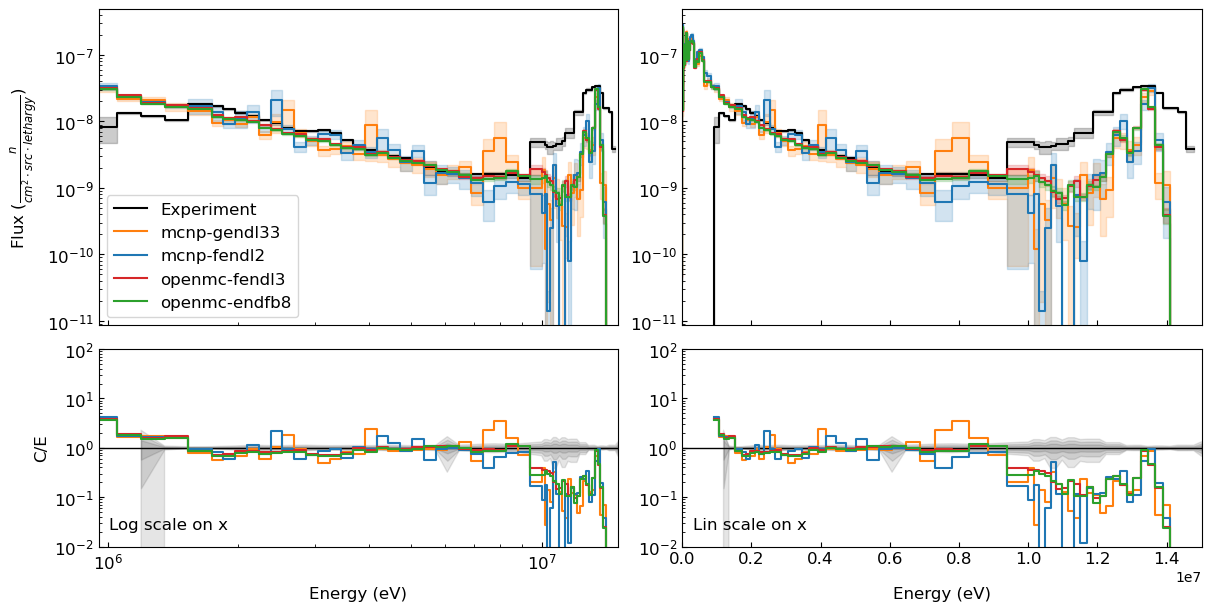

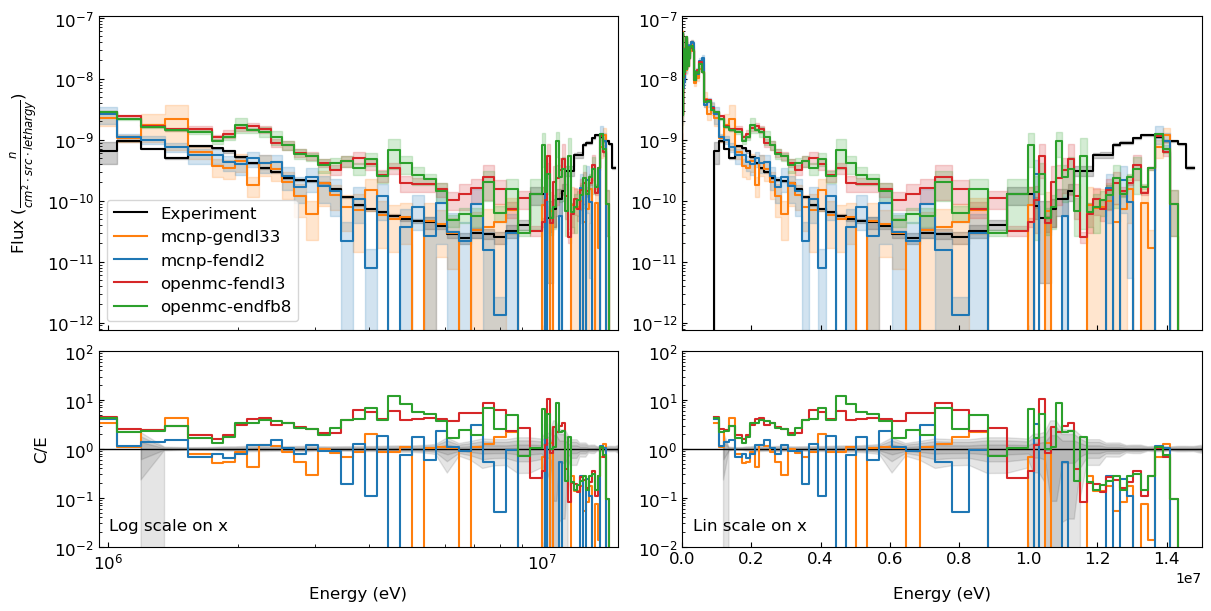

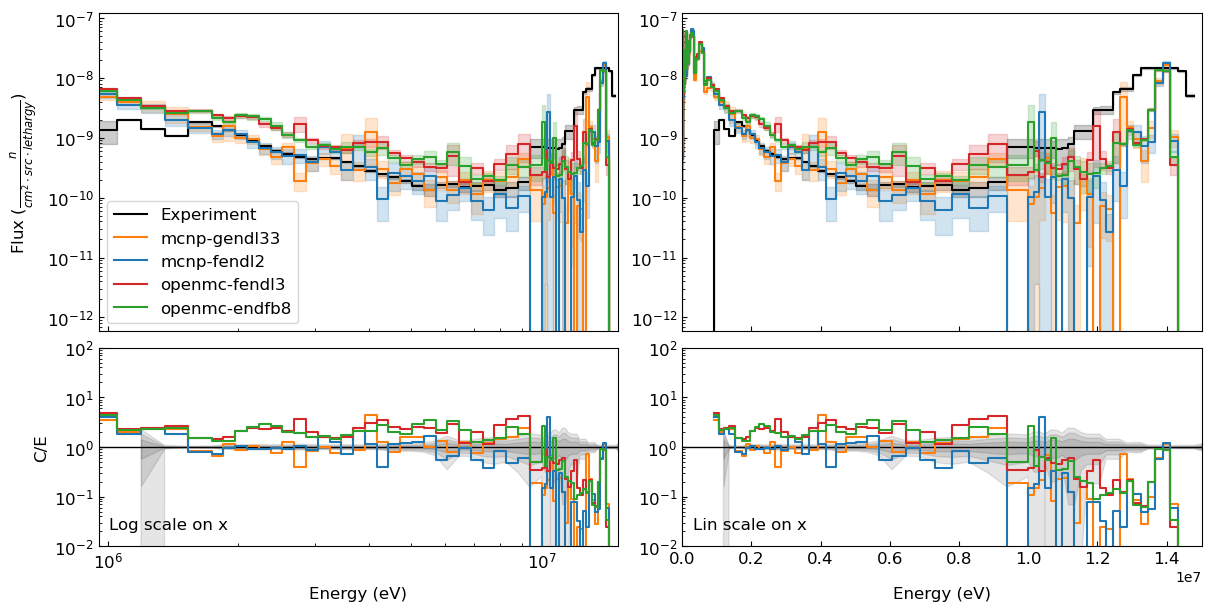

In [8]:
# Spectra with computed results binning

for i, dl in enumerate(detector_list):

    measured = experiment_file.get_tally_dataframe(f'nspectrum_{dl}')
    mcnp_jendl33 = mcnp_jendl33_file.get_tally_dataframe(f'nspectrum_{dl}')
    mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'nspectrum_{dl}')
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'nspectrum_{dl}')
    openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'nspectrum_{dl}')

    measured = ofb.rescale_to_lethargy(ofb.rebin_spectrum(measured, mcnp_jendl33['energy low [eV]'], mcnp_jendl33['energy high [eV]']))
    mcnp_jendl33 = ofb.rescale_to_lethargy(mcnp_jendl33)
    mcnp_fendl2 = ofb.rescale_to_lethargy(mcnp_fendl2)
    openmc_fendl3 = ofb.rescale_to_lethargy(openmc_fendl3)
    openmc_endfb8 = ofb.rescale_to_lethargy(openmc_endfb8)

    # generate figure
    plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel, dtype_label=detector_labels[i])
    plot.add_reference_results(reference_data=measured, label='Experiment')
    plot.add_computed_results(computed_data=mcnp_jendl33, color='tab:orange', alpha=1, label='mcnp-gendl33')
    plot.add_computed_results(computed_data=mcnp_fendl2, color='tab:blue', alpha=1, label='mcnp-fendl2')
    plot.add_computed_results(computed_data=openmc_fendl3, color='tab:red', alpha=1, label='openmc-fendl3')
    plot.add_computed_results(computed_data=openmc_endfb8, color='tab:green', alpha=1, label='openmc-endfb8')

The quality of this benchmark has been classified as _intermediate_ in SINBAD for the following reasons:
- The neutron source characteristics (energy and angular distributions) have not been provided
- The response function, other specs and related sources of uncertainty for the spectrometers have not been provided

[1] Morimoto, Y., et al. "Dogleg Diet Streaming Experiment with 14 MeV Neutron Source." Journal of Nuclear Science and Technology 41.sup4 (2004): 42-45. https://doi.org/10.1080/00223131.2004.10875640\
[2] S. F. software, “Attila4MC” https://silverfirsoftware.com/Attila4MC.php (2023) \
[3] Kodeli, I. A., et al. "SINBAD–Radiation shielding benchmark experiments." Annals of Nuclear Energy 159 (2021): 108254. https://doi.org/10.1016/j.anucene.2021.108254 \
[4] Trkov, A., et al. "IRDFF-II: a new neutron metrology library." Nuclear Data Sheets 163 (2020): 1-108. https://doi.org/10.1016/j.nds.2019.12.001